# Credit Card Fraud Detection

This notebook uses the credit card fraud detection dataset, and explores different binary classification models that can identify transactions as either fraudulent or valid, based on provided, *historical* data.

### Dataset Info

The payment fraud data set was downloaded from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/data). This has features and labels for thousands of credit card transactions, each of which is labeled as fraudulent or valid.

### Load Libraries

In [52]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.linear_model import LinearRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

## Loading and Exploring the Data

Next, I am loading the data and unzipping the data in the file `creditcardfraud.zip`. This directory will hold one csv file of all the transaction data, `creditcard.csv`.

In [2]:
# read in the csv file
local_data = 'creditcard.csv'

# print out some data
transaction_df = pd.read_csv(local_data)
print('Data shape (rows, cols): ', transaction_df.shape)
print()
transaction_df.head()

Data shape (rows, cols):  (284807, 31)



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# check for importantant information
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
transaction_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Checking for class imbalance
We can see that there's  indeed a huge amount of class imbalance. We'll need to balance this later.

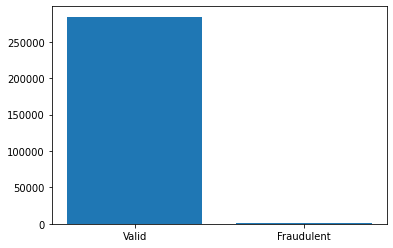

In [5]:
plt.bar(transaction_df['Class'].unique(), transaction_df['Class'].value_counts(), tick_label = ['Valid', 'Fraudulent']);

### Calculating the percentage of fraudulent data

Take a look at the distribution of this transaction data over the classes, valid and fraudulent. 

The function `fraudulent_percentage`, below, Counts up the number of data points in each class and calculate the *percentage* of the data points that are fraudulent.

In [6]:
# Calculate the fraction of data points that are fraudulent
def fraudulent_percentage(transaction_df):
    '''Calculate the fraction of all data points that have a 'Class' label of 1; fraudulent.
       :param transaction_df: Dataframe of all transaction data points; has a column 'Class'
       :return: A fractional percentage of fraudulent data points/all points
    '''
    
    # your code here
    all_data_points = len(transaction_df.Class)
    fraudulent_data_points = len(transaction_df.Class[transaction_df.Class==1])
    
    fraudulent_percentage = fraudulent_data_points/all_data_points
    
    return fraudulent_percentage

In [7]:
# call the function to calculate the fraud percentage
fraud_percentage = fraudulent_percentage(transaction_df)

print(f'Fraudulent percentage = {round(fraud_percentage*100, 2)}%')
print('Total # of fraudulent pts: ', fraud_percentage*transaction_df.shape[0])
print('Out of (total) pts: ', transaction_df.shape[0])


Fraudulent percentage = 0.17%
Total # of fraudulent pts:  492.0
Out of (total) pts:  284807


### Split into train/test datasets
So, we'll need to split the data into separate training and test sets.

In [8]:
# Get features
features = transaction_df.iloc[:, :-1]
# Get labels
labels = transaction_df['Class']

In [29]:
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(features, labels, train_size=0.2, random_state=42)

Let's create a helper function to check for performance

In [10]:
def performance_check(y_test, x_test, model):
    """
    Helper function to help check for performance
    """
    print(classification_report(y_test, model.predict(x_test)))
    print('-----------------------------------------------------')
    print('Confusion Matrix\n')
    print(confusion_matrix(y_test,  model.predict(x_test)))
    

# Modeling
1. Gradient Boosting Classifier
3. Deep Learning

In [11]:
# Instantiate the Gradient Boosting model
gradient_boost = GradientBoostingClassifier()

# Fit on the train and test set
gradient_boost.fit(x_train, y_train)

GradientBoostingClassifier()

In [12]:
# Check for performance
performance_check(y_test, x_test, gradient_boost)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227459
           1       0.92      0.63      0.75       387

    accuracy                           1.00    227846
   macro avg       0.96      0.81      0.87    227846
weighted avg       1.00      1.00      1.00    227846

-----------------------------------------------------
Confusion Matrix

[[227439     20]
 [   145    242]]


In [27]:
# Instantiate the XGB model
xgb = XGBClassifier()

# Fit on the train and test set
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [28]:
# Check for performance
performance_check(y_test, x_test, xgb)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227459
           1       0.94      0.75      0.84       387

    accuracy                           1.00    227846
   macro avg       0.97      0.88      0.92    227846
weighted avg       1.00      1.00      1.00    227846

-----------------------------------------------------
Confusion Matrix

[[227440     19]
 [    96    291]]


Let's try an Artificial Neural Network

In [30]:
model = Sequential([
    Dense(64, input_shape=(x_train.shape[1],), activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1984      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Fit and train the model on train data
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=3)

Epoch 1/3
1781/1781 [==============================] - 60s 33ms/step - loss: 24.1081 - accuracy: 0.9938 - val_loss: 6.9947 - val_accuracy: 0.9983
Epoch 2/3
1781/1781 [==============================] - 59s 33ms/step - loss: 9.5335 - accuracy: 0.9959 - val_loss: 15.8246 - val_accuracy: 0.9983
Epoch 3/3
1781/1781 [==============================] - 59s 33ms/step - loss: 9.1859 - accuracy: 0.9964 - val_loss: 8.8951 - val_accuracy: 0.9983


In [33]:
pred = model.predict(x_test)
pred = np.where(pred < 0.5, 0, 1)

7121/7121 [==============================] - 27s 4ms/step


In [34]:
# Check for performance ANN
print(classification_report(y_test, pred))
print('-----------------------------------------------------')
print('Confusion Matrix\n')
print(confusion_matrix(y_test,  pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227459
           1       0.20      0.00      0.01       387

    accuracy                           1.00    227846
   macro avg       0.60      0.50      0.50    227846
weighted avg       1.00      1.00      1.00    227846

-----------------------------------------------------
Confusion Matrix

[[227455      4]
 [   386      1]]


# Model Improvements

Both the Gradient Boosting and Artificial Neural Network got a high accuracy, but still mis-classified fraudulent and valid data points. From the `Confusion Matrix` above, you can clearly see the Gradient Boosting, classifying more than 100 points as false negatives (incorrectly labelled fraudulent transactions), 24 points as false positives (incorrectly labelled, valid transactions).

**1. Model optimization**
* Since we want a model that will catch almost *all* cases of fraudulent transactions, even if it means a higher number of false positives(valid incorrectly labelled as fradulent), then we'd want as few **false negatives** as possible, hence we do not want to optimize for accuracy only. Instead, we want to optimize for a metric that can help us decrease the number of **false negatives**.

**2. Imbalanced training data**
* The dataset is quite imbalanced, were only about 0.17% of the training data was labeled as fraudulent. So, even if a model labels **all** of our data as valid, it will still have a high accuracy. 
* This may result in some overfitting towards valid data, which accounts for some **false negatives**; cases in which fraudulent data (1) is incorrectly classified as valid (0).

#### Balancing imblanced data by downsampling the majority class

In [35]:
# Use counter to count number of samples in the target column
counter = Counter(y_train)
print('Before', counter)

# Instantiate the RandomUndersampler()
under_sample = RandomUnderSampler()

# Undersample the majority
X_train_ru, y_train_ru = under_sample.fit_resample(x_train, y_train)
counter = Counter(y_train_ru)
print('After',counter)

Before Counter({0: 56856, 1: 105})
After Counter({0: 105, 1: 105})


In [36]:
# Fit a new model on balanced data
xgb = XGBClassifier()
xgb.fit(X_train_ru, y_train_ru)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [38]:
performance_check(y_test, x_test, xgb)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    227459
           1       0.06      0.89      0.12       387

    accuracy                           0.98    227846
   macro avg       0.53      0.93      0.55    227846
weighted avg       1.00      0.98      0.99    227846

-----------------------------------------------------
Confusion Matrix

[[222310   5149]
 [    44    343]]


After, balancing the imbalanced class by downsampling the majority class, we see that the model improved greatly

After undersampling, we can see that we have improved the false negativa score from 72% to 88%, and reduced the misclassified points to 46.

Let's explore which features are most important.

In [53]:
# create a dictionary of different algorithms 
models = {
        'XGBoostClassifier':XGBClassifier(),
        'GradientBoostingClassifier':GradientBoostingClassifier(),
        'RandomForest':RandomForestClassifier(),
        'DecisionTreesClassifier':DecisionTreeClassifier(),
        'ExtraTreesClassifier':ExtraTreesClassifier(),
        'AdaBoostClassifier':AdaBoostClassifier()}

In [54]:
# helper funtion to compute the score, RMSE, time on the training and testing set

def pipeline(models, X_train, X_test, y_train, y_test):
    """
    This function iteratively goes through all the models defined in the dictionary and 
    computes the Train_score, Test_score, MSE, MAE and RMSE.
    
    Parameters: model, training set(X_train), test_set(X_test), train_labels(y_train), and test_labels(y_test).
    
    Returns: This funtion returns a dataFrame containing calculations of each models and also plots bar
            chart showing how each models performs.
    """
    
    # store properties of each model
    prop = []
    
    # loop through the dictionary of models
    for clf_name, model in models.items():
        # empty dict for storing properties of each models
        clf_dict = {}
        # store the name of each model
        clf_dict['Name'] = clf_name
        # fit the regressor model
        model.fit(X_train, y_train)
        # compute the Train_score
        clf_dict['Train_score'] = model.score(X_train, y_train)
        # compute the test scores
        clf_dict['Test_score'] = model.score(X_test, y_test)
        # compute the accuracy
        clf_dict['Accuracy'] = round(accuracy_score(y_test, model.predict(x_test)), 3)
        #compute the recall score
        clf_dict['Recall'] = round(recall_score(y_test, model.predict(x_test)), 3)
        # compute the precision score
        clf_dict['Precision'] = round(precision_score(y_test, model.predict(x_test)), 3)
     
        # append the properties of a single regressor to the prop list
        prop.append(clf_dict)
     
    # create a dataframe with a list of all the model properties
    summary_df = pd.DataFrame(prop)
        
        
    return summary_df

In [55]:
# execute the function
pipeline(models, X_train_ru, x_test, y_train_ru, y_test)

,Name,Train_score,Test_score,Accuracy,Recall,Precision
0,XGBoostClassifier,1.0,0.977208,0.977,0.886,0.062
1,GradientBoostingClassifier,1.0,0.962944,0.963,0.876,0.039
2,RandomForest,1.0,0.989401,0.989,0.868,0.124
3,DecisionTreesClassifier,1.0,0.882754,0.883,0.881,0.013
4,ExtraTreesClassifier,1.0,0.993342,0.993,0.871,0.187
5,AdaBoostClassifier,1.0,0.956879,0.957,0.884,0.034


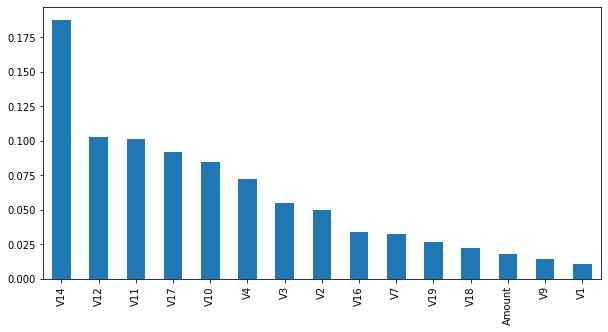

In [228]:
plt.figure(figsize=(10,5))
# get feature importance
feature_importance = pd.Series(RF.feature_importances_, index=x_train.columns)
feature_importance.nlargest(15).plot(kind='bar');

In [229]:
# Get names of top 15 features
indices = np.argsort(feature_importance)[::-1]
names = [x_train.columns[i] for i in indices]

In [236]:
# Use top 10 features to train new model
x_train_best = x_train[names[0:10]]
x_test_best = x_test[names[0:10]]

In [237]:
counter = Counter(y_train)
print('Before', counter)

under_sample = RandomUnderSampler()

X_train_ru, y_train_ru = under_sample.fit_resample(x_train_best, y_train)

counter = Counter(y_train_ru)
print('After',counter)

Before Counter({0: 56856, 1: 105})
After Counter({0: 105, 1: 105})


Fit a Random Forest on the new downsampled dataset

In [238]:
RF = RandomForestClassifier()
RF.fit(X_train_ru, y_train_ru)

RandomForestClassifier()

In [240]:
performance_check(y_test, x_test_best, RF)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    227459
           1       0.07      0.88      0.12       387

    accuracy                           0.98    227846
   macro avg       0.53      0.93      0.56    227846
weighted avg       1.00      0.98      0.99    227846

-----------------------------------------------------
Confusion Matrix

[[222650   4809]
 [    46    341]]


### Save Model

In [152]:
pickle.dump(RF, open('RF_model.pkl', 'wb'))